# Data preparation section

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
installed_packages = [
    "opensmile",
    "google",
    "treelib",
    "graphviz",
]

for package in installed_packages:
    !pip install {package}

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import pandas as pd
import json

In [4]:
import opensmile

smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_set=opensmile.FeatureSet.eGeMAPS,
#     feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)


C:\Users\Matas\AppData\Roaming\Python\Python310\site-packages\opensmile\core\smile.py:256: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(


In [5]:
import glob

try:
    files = glob.glob("../data/raw/RAVDESS/*/*.wav")
except:
    from google.colab import drive
    drive.mount('/content/gdrive')
    files = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/IP/data/RAVDESS/*/*.wav")

In [6]:
file_name_to_emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

In [7]:
emotion_to_positivity_mapping = {
    "neutral": "positive",
    "calm": "positive",
    "happy": "positive",
    "sad": "negative",
    "angry": "negative",
    "fearful": "negative",
    "disgust": "negative",
    "surprised": "positive",
}

##### Data reading and normalisation

In [8]:
speech_data = smile.process_files(files)

In [9]:
normalised_speech_data=(speech_data-speech_data.mean())/speech_data.std()
normalised_speech_data.dropna(axis='columns', inplace=True)

In [10]:
emotion_labels = [file_name_to_emotion_mapping[file.split("-")[-5]] for file in files]

##### Splitting the data into training, validation and test sets

In [11]:
from sklearn.model_selection import train_test_split

speeches = normalised_speech_data
emotions = emotion_labels

speeches_train_and_val, speeches_test, emotions_train_and_val, emotions_test = train_test_split(speeches, emotions, test_size=0.2, random_state=42, stratify=emotions)
speeches_train, speeches_val, emotions_train, emotions_val = train_test_split(speeches_train_and_val, emotions_train_and_val, test_size=0.25, random_state=42, stratify=emotions_train_and_val)

In [12]:
emotions_binary_train = [emotion_to_positivity_mapping[emotion] for emotion in emotions_train]
emotions_binary_val = [emotion_to_positivity_mapping[emotion] for emotion in emotions_val]
emotions_binary_test = [emotion_to_positivity_mapping[emotion] for emotion in emotions_test]

In [13]:
# Pandas dataframes keep the old indexing after sampling, but I need it to be sequential, thus, a reset for the index
speeches_train.reset_index(drop=True, inplace=True)
speeches_val.reset_index(drop=True, inplace=True)
speeches_test.reset_index(drop=True, inplace=True)

In [14]:
from collections import Counter

print(f"{len(speeches_train)=}\t\t{len(emotions_train)=}")
print(f"{len(speeches_val)=}\t\t{len(emotions_val)=}")
print(f"{len(speeches_test)=}\t\t{len(emotions_test)=}")

print(f"{Counter(emotions_train)=}")
print(f"{Counter(emotions_val)=}")
print(f"{Counter(emotions_test)=}")

len(speeches_train)=864		len(emotions_train)=864
len(speeches_val)=288		len(emotions_val)=288
len(speeches_test)=288		len(emotions_test)=288
Counter(emotions_train)=Counter({'calm': 116, 'angry': 115, 'fearful': 115, 'sad': 115, 'happy': 115, 'surprised': 115, 'disgust': 115, 'neutral': 58})
Counter(emotions_val)=Counter({'sad': 39, 'disgust': 39, 'angry': 39, 'calm': 38, 'surprised': 38, 'fearful': 38, 'happy': 38, 'neutral': 19})
Counter(emotions_test)=Counter({'happy': 39, 'fearful': 39, 'surprised': 39, 'sad': 38, 'calm': 38, 'angry': 38, 'disgust': 38, 'neutral': 19})


# Classifier comparison section

##### Building classifiers

In [15]:
from locale import Error
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

def fit_predict_and_score_classifier(classifier, data_train, data_val, labels_train, labels_val, label_set):
    classifier.fit(data_train, labels_train)
    results = {"train": {}, "val": {}}
    
    for set_type in ["train", "val"]:
        if set_type == "train":
            data = data_train
            labels = labels_train
        elif set_type == "val":
            data = data_val
            labels = labels_val
        else:
            raise Error("Undefined data set type")

        labels_predicted = classifier.predict(data)

        results[set_type]["predictions"] = labels_predicted
        results[set_type]["accuracy"] = metrics.accuracy_score(labels, labels_predicted)
        results[set_type]["precision"] = metrics.precision_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["recall"] = metrics.recall_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["F1"] = metrics.f1_score(labels, labels_predicted, average="macro", zero_division=1)

    return results

def create_result_table(results):
    first_key = list(results.keys())[0]
    second_key = list(results[first_key].keys())[0]
    table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
    for classifier_name, classifier_data in results.items():
        for set_type, set_metrics in classifier_data.items():
              # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
            new_row = {"Classifier": classifier_name, "Set type": set_type} | set_metrics
            table = table.append(new_row, ignore_index=True)
    return table

# def create_result_table(results):
#     first_key = list(results.keys())[0]
#     second_key = list(results[first_key].keys())[0]
#     table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
#     for classifier_name, classifier_data in results.items():
#         for set_type, set_metrics in classifier_data.items():
#               # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
#             new_row = pd.DataFrame({"Classifier": classifier_name, "Set type": set_type} | set_metrics)
#             table = pd.concat([table, new_row], ignore_index=True)
#     return table

def calculate_f1_scores_by_class(labels_predicted, labels):
    all_labels = sorted(list(set(labels)))
    matrix_dimension = range(len(set(labels)))
    matrix = metrics.confusion_matrix(labels, labels_predicted, labels=all_labels)

    recalls = [matrix[index, index] / row_sum for index, row_sum in enumerate(np.sum(matrix, axis=1))]
    precisions = [matrix[index, index] / column_sum for index, column_sum in enumerate(np.sum(matrix, axis=0))]

    f1_scores = {label: {} for label in all_labels}
    for index, label in enumerate(all_labels):
        f1_scores[label] = 2 * (precisions[index] * recalls[index]) / (precisions[index] + recalls[index])

    return f1_scores

In [16]:
# These parameters are repeated, so they are unwrapped while calling functions to reduce clutter
multi_class_parameters = (speeches_train, speeches_val, emotions_train, emotions_val, set(emotions))
binary_parameters = (speeches_train, speeches_val, emotions_binary_train, emotions_binary_val, set(["positive", "negative"]))
initial_classifier_results = {}
initial_classifier_results_binary = {}

In [17]:
dummy_classifier_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_classifier_stratified = DummyClassifier(strategy="stratified")
logistic_regression = LogisticRegression(max_iter=1000)
svc = SVC()

##### Multi-class classification

In [18]:
initial_classifier_results["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *multi_class_parameters)

In [19]:
initial_classifier_results["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *multi_class_parameters)

In [20]:
initial_classifier_results["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *multi_class_parameters)

In [21]:
initial_classifier_results["svc"] = fit_predict_and_score_classifier(svc, *multi_class_parameters)

In [22]:
initial_classifier_results_table = create_result_table(initial_classifier_results)
display(initial_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[happy, disgust, surprised, angry, sad, calm, ...",0.138889,0.134778,0.134483,0.134392
3,dummy_classifier_stratified,val,"[fearful, happy, fearful, calm, angry, disgust...",0.138889,0.137899,0.133266,0.134447
4,logistic_regression,train,"[disgust, fearful, neutral, sad, surprised, su...",0.812500,0.809383,0.810139,0.809411
5,logistic_regression,val,"[fearful, calm, surprised, sad, fearful, calm,...",0.576389,0.554396,0.557102,0.554253
6,svc,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.811343,0.817080,0.799382,0.803904
7,svc,val,"[sad, calm, surprised, sad, fearful, calm, neu...",0.586806,0.588006,0.573802,0.574728


In [23]:
f1_scores = calculate_f1_scores_by_class(initial_classifier_results["svc"]["val"]["predictions"], emotions_val)
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score}")

angry: 0.6461538461538461
calm: 0.627906976744186
disgust: 0.631578947368421
fearful: 0.5647058823529411
happy: 0.5454545454545455
neutral: 0.4117647058823529
sad: 0.42666666666666664
surprised: 0.7435897435897436


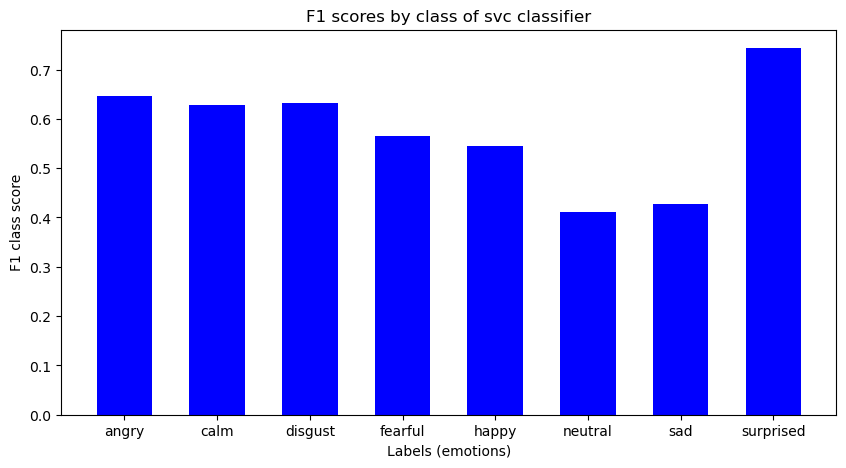

In [24]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions = list(f1_scores.keys())
f1_score_values = list(f1_scores.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions, f1_score_values, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of svc classifier")
plt.show()

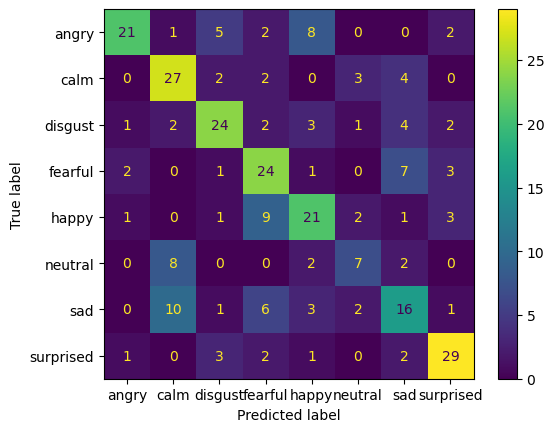

In [25]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(emotions_val, initial_classifier_results["svc"]["val"]["predictions"])
plt.show()

##### Binary classification

In [26]:
initial_classifier_results_binary["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *binary_parameters)

In [27]:
initial_classifier_results_binary["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *binary_parameters)

In [28]:
initial_classifier_results_binary["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *binary_parameters)

In [29]:
initial_classifier_results_binary["svc"] = fit_predict_and_score_classifier(svc, *binary_parameters)

In [30]:
initial_classifier_results_table_binary = create_result_table(initial_classifier_results_binary)
display(initial_classifier_results_table_binary)

C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[negative, negative, negative, negative, negat...",0.532407,0.766204,0.500000,0.347432
1,dummy_classifier_most_frequent,val,"[negative, negative, negative, negative, negat...",0.538194,0.769097,0.500000,0.349887
2,dummy_classifier_stratified,train,"[negative, positive, positive, negative, negat...",0.480324,0.479486,0.479412,0.479263
3,dummy_classifier_stratified,val,"[positive, negative, positive, negative, negat...",0.465278,0.464467,0.464274,0.464011
4,logistic_regression,train,"[positive, negative, positive, negative, posit...",0.783565,0.782643,0.782727,0.782684
5,logistic_regression,val,"[negative, positive, negative, negative, negat...",0.704861,0.703367,0.703929,0.703571
6,svc,train,"[negative, negative, positive, negative, posit...",0.891204,0.891756,0.889690,0.890485
7,svc,val,"[positive, positive, negative, negative, negat...",0.763889,0.762581,0.761969,0.762238


In [31]:
f1_scores_binary = calculate_f1_scores_by_class(initial_classifier_results_binary["logistic_regression"]["val"]["predictions"], emotions_binary_val)
for emotion, score in f1_scores_binary.items():
    print(f"{emotion}: {score}")

negative: 0.723127035830619
positive: 0.6840148698884759


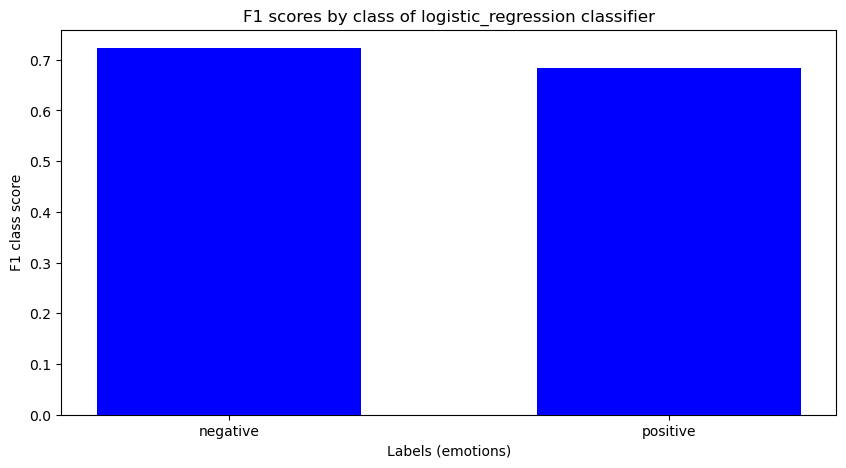

In [32]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions_binary = list(f1_scores_binary.keys())
f1_score_values_binary = list(f1_scores_binary.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions_binary, f1_score_values_binary, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of logistic_regression classifier")
plt.show()

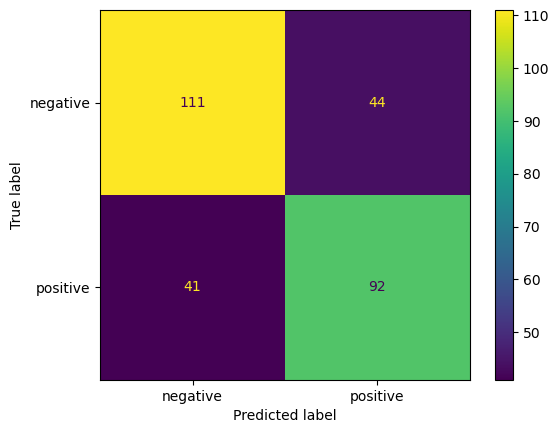

In [33]:
metrics.ConfusionMatrixDisplay.from_predictions(emotions_binary_val, initial_classifier_results_binary["logistic_regression"]["val"]["predictions"])
plt.show()

##### Feature visualisation

In [34]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [35]:
import treelib

def add_node(tree, feature, is_feature):
    feature_parent, delimiter, feature_name = feature.rpartition("_")
    
    if not tree.contains(feature_parent):
        add_node(tree, feature_parent, False)
    
    try:
        tree.create_node(tag=feature_name, identifier=feature, parent=feature_parent, data=is_feature)
    except treelib.exceptions.DuplicatedNodeIdError as error:
        # Such node already exists, potentially because recursive parent creation created it before reaching the node itself
        if is_feature:
            feature_tree.get_node(feature).data = True

feature_tree = treelib.Tree()

feature_tree.create_node(tag="ROOT", identifier="", data=False)

for column in speeches_train.columns:
    add_node(feature_tree, column, True)

In [36]:
# Taken from https://medium.com/dive-into-ml-ai/tree-data-visualization-with-treelib-71633f6fd8fb
import subprocess

feature_tree.to_graphviz("Feature hierarchy graph description.dot")
subprocess.call(["dot", "-Tsvg", "hello.dot", "-o", "Feature hierarchy graph.svg"])

2

In [37]:
# feature_tree.all_nodes()

In [38]:
feature_endings = []
analysis_by_endings = {}

for column in speeches_train.columns:
    feature_parent, delimiter, ending = column.rpartition("_")
    feature_endings.append(ending)
    
    if ending not in analysis_by_endings.keys():
        analysis_by_endings[ending] = {"features": []}
    
    analysis_by_endings[ending]["features"].append(column)
    
print(Counter(feature_endings))

Counter({'amean': 35, 'stddevNorm': 30, 'percentile20.0': 2, 'percentile50.0': 2, 'percentile80.0': 2, 'pctlrange0-2': 2, 'meanRisingSlope': 2, 'stddevRisingSlope': 2, 'meanFallingSlope': 2, 'stddevFallingSlope': 2, 'loudnessPeaksPerSec': 1, 'VoicedSegmentsPerSec': 1, 'MeanVoicedSegmentLengthSec': 1, 'StddevVoicedSegmentLengthSec': 1, 'MeanUnvoicedSegmentLength': 1, 'StddevUnvoicedSegmentLength': 1, 'dBp': 1})


#### Feature optimisation section

In [39]:
classifier_for_feature_optimisation = svc
baseline_f1_score = initial_classifier_results["svc"]["val"]["F1"]

features_used_for_testing = 10_000 # 50 # 600

speeches_train_copy = speeches_train.copy()
speeches_train_copy.drop(speeches_train.columns[features_used_for_testing:], axis=1, inplace=True)
speeches_val_copy = speeches_val.copy()
speeches_val_copy.drop(speeches_val.columns[features_used_for_testing:], axis=1, inplace=True)

In [40]:
# ### Separated model to reduce time demands

# from ipywidgets import IntProgress

# # raise Exception("Prevent this cell from running so that it doesn't get stuck")

# endings_progress_bar = IntProgress(
#     min=0,
#     max=len(analysis_by_endings.keys())-1,
#     description = f"0/{len(analysis_by_endings)-1} ending"
# )

# progress_bar = IntProgress(
#     min=0,
#     max=len(speeches_train_copy.columns)-1,
#     description = f"0th feature"
# )

# inner_progress_bar = IntProgress(
#     min=0,
#     max=len(speeches_train.columns)-1,
#     description = f"0/{len(speeches_train_copy.columns)-1}"
# )

# display(endings_progress_bar)
# display(progress_bar)
# display(inner_progress_bar)

# for ending_index, data in enumerate(list(analysis_by_endings.values())):
#     data["final_data_frame"] = pd.DataFrame()
#     data["removed_features"] = []

#     speeches_train_copy = speeches_train.copy()[data["features"]]
#     speeches_val_copy = speeches_val.copy()[data["features"]]
    
#     progress_bar.value = 0
#     progress_bar.max = len(speeches_train_copy.columns)-1
#     inner_progress_bar.value = 0
#     inner_progress_bar.max = len(speeches_train_copy.columns)-1
#     endings_progress_bar.description = f"{ending_index}/{len(analysis_by_endings)-1} ending"
    
#     for feature_index in range(len(speeches_train_copy.columns)-1): # -1 so that the last feature is not deleted and an empty DataFrame is passed
#         progress_bar.description = f"{feature_index}/{len(speeches_train_copy.columns)-1} feature"

#         # Setting the new baseline
#         result = fit_predict_and_score_classifier(
#                 classifier_for_feature_optimisation,
#                 speeches_train_copy,
#                 speeches_val_copy, # speeches_val,
#                 emotions_train,
#                 emotions_val,
#                 set(emotions)
#             )
#         max_f1_score = result["val"]["F1"]
#         column_to_remove = None

#         # Finding the worst F1-reducing feature
#         inner_progress_bar.max = len(speeches_train_copy.columns)
#         inner_progress_bar.value = 0

#         for index, column in enumerate(speeches_train_copy.columns):
#             inner_progress_bar.description = f"{index}/{len(speeches_train_copy.columns)-1}"

#             result = fit_predict_and_score_classifier(
#                 classifier_for_feature_optimisation,
#                 speeches_train_copy.drop([column], axis=1),
#                 speeches_val_copy.drop([column], axis=1), # speeches_val.drop([column], axis=1),
#                 emotions_train,
#                 emotions_val,
#                 set(emotions)
#             )
#             f1_score = result["val"]["F1"]

#             if f1_score > max_f1_score:
#                 max_f1_score = f1_score
#                 column_to_remove = column

#             inner_progress_bar.value += 1

#         # Removing the worst feature
#         if column_to_remove is not None:
#             speeches_train_copy.drop([column_to_remove], axis=1, inplace=True)
#             speeches_val_copy.drop([column_to_remove], axis=1, inplace=True) # speeches_val.drop([column_to_remove], axis=1, inplace=True)
#             data["removed_features"].append((column_to_remove, max_f1_score, max_f1_score - f1_score))
#             progress_bar.value += 1
#         else:
#             progress_bar.value = progress_bar.max
#             inner_progress_bar.value = inner_progress_bar.max
#             data["final_data_frame"] = speeches_train_copy.copy()
#             break
            
#     endings_progress_bar.value += 1

In [41]:
### Full version (slow but checking everything)

from ipywidgets import IntProgress

# raise Exception("Prevent this cell from running so that it doesn't get stuck")

progress_bar = IntProgress(
    min=0,
    max=len(speeches_train_copy.columns)-1,
    description = f"0th feature"
)

inner_progress_bar = IntProgress(
    min=0,
    max=len(speeches_train.columns)-1,
    description = f"0/{len(speeches_train_copy.columns)-1}"
)

display(progress_bar)
display(inner_progress_bar)

data = []
final_data_frame = None
# data["final_data_frame"] = pd.DataFrame()
# data["removed_features"] = []

speeches_train_copy = speeches_train.copy()
speeches_val_copy = speeches_val.copy()

progress_bar.value = 0
progress_bar.max = len(speeches_train_copy.columns)-1
inner_progress_bar.value = 0
inner_progress_bar.max = len(speeches_train_copy.columns)-1

for feature_index in range(len(speeches_train_copy.columns)-1): # -1 so that the last feature is not deleted and an empty DataFrame is passed
    progress_bar.description = f"{feature_index}/{len(speeches_train_copy.columns)-1} feature"

    # Setting the new baseline
    result = fit_predict_and_score_classifier(
            classifier_for_feature_optimisation,
            speeches_train_copy,
            speeches_val_copy, # speeches_val,
            emotions_train,
            emotions_val,
            set(emotions)
        )
    max_f1_score = result["val"]["F1"]
    column_to_remove = None

    # Finding the worst F1-reducing feature
    inner_progress_bar.max = len(speeches_train_copy.columns)
    inner_progress_bar.value = 0

    for index, column in enumerate(speeches_train_copy.columns):
        inner_progress_bar.description = f"{index}/{len(speeches_train_copy.columns)-1}"

        result = fit_predict_and_score_classifier(
            classifier_for_feature_optimisation,
            speeches_train_copy.drop([column], axis=1),
            speeches_val_copy.drop([column], axis=1), # speeches_val.drop([column], axis=1),
            emotions_train,
            emotions_val,
            set(emotions)
        )
        f1_score = result["val"]["F1"]

        if f1_score > max_f1_score:
            max_f1_score = f1_score
            column_to_remove = column

        inner_progress_bar.value += 1

    # Removing the worst feature
    if column_to_remove is not None:
        speeches_train_copy.drop([column_to_remove], axis=1, inplace=True)
        speeches_val_copy.drop([column_to_remove], axis=1, inplace=True) # speeches_val.drop([column_to_remove], axis=1, inplace=True)
        data.append((column_to_remove, max_f1_score, max_f1_score - f1_score))
        progress_bar.value += 1
    else:
        progress_bar.value = progress_bar.max
        inner_progress_bar.value = inner_progress_bar.max
        final_data_frame = speeches_train_copy.copy()
        break

IntProgress(value=0, description='0th feature', max=87)

IntProgress(value=0, description='0/87', max=87)

In [42]:
data

[('F3frequency_sma3nz_stddevNorm', 0.6011863732947672, 0.01983866990759009),
 ('loudness_sma3_percentile50.0', 0.6087547838455578, 0.01300491714563723),
 ('F1frequency_sma3nz_amean', 0.6122133970818181, 0.013486134970291608),
 ('mfcc3V_sma3nz_stddevNorm', 0.6162671124159734, 0.02051626238826776),
 ('mfcc1V_sma3nz_stddevNorm', 0.6196640810727498, 0.0264983722309462)]

In [43]:
removed_columns = [entry[0] for entry in data]
speeches_train_pruned = speeches_train.copy().drop(removed_columns, axis=1)
speeches_val_pruned = speeches_val.copy().drop(removed_columns, axis=1)
speeches_test_pruned = speeches_test.copy().drop(removed_columns, axis=1)

multi_class_pruned_parameters = (speeches_train_pruned, speeches_val_pruned, emotions_train, emotions_val, set(emotions))

In [44]:
print(len(speeches_train.columns), len(speeches_train_pruned.columns))

88 83


In [45]:
initial_classifier_results["svc_pruned"] = fit_predict_and_score_classifier(svc, *multi_class_parameters)

In [46]:
post_prunation_classifier_results_table = create_result_table(initial_classifier_results)
display(post_prunation_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[happy, disgust, surprised, angry, sad, calm, ...",0.138889,0.134778,0.134483,0.134392
3,dummy_classifier_stratified,val,"[fearful, happy, fearful, calm, angry, disgust...",0.138889,0.137899,0.133266,0.134447
4,logistic_regression,train,"[disgust, fearful, neutral, sad, surprised, su...",0.812500,0.809383,0.810139,0.809411
5,logistic_regression,val,"[fearful, calm, surprised, sad, fearful, calm,...",0.576389,0.554396,0.557102,0.554253
6,svc,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.811343,0.817080,0.799382,0.803904
7,svc,val,"[sad, calm, surprised, sad, fearful, calm, neu...",0.586806,0.588006,0.573802,0.574728
8,svc_pruned,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.811343,0.817080,0.799382,0.803904
9,svc_pruned,val,"[sad, calm, surprised, sad, fearful, calm, neu...",0.586806,0.588006,0.573802,0.574728


##### Hyperparameter optimisation

In [47]:
from sklearn.model_selection import GridSearchCV

svc_parameters = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 5, 10, 20, 50],
    "gamma": ["scale", "auto"],
    "shrinking": [True, False],
#     "max_iter": [-1, 100, 10_000],
}

parametrised_svc = GridSearchCV(svc, svc_parameters)
parametrised_svc.fit(speeches_train_pruned, emotions_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10, 20, 50],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]})

In [48]:
parametrised_svc.cv_results_.items()

dict_items([('mean_fit_time', array([0.02917299, 0.03437405, 0.03749976, 0.04375005, 0.05508027,
       0.13435125, 0.04375277, 0.0437427 , 0.0281261 , 0.03438201,
       0.03749876, 0.0375001 , 0.04679308, 0.04062996, 0.03752093,
       0.04061651, 0.06249537, 0.09850769, 0.03265667, 0.03428831,
       0.04146667, 0.03543816, 0.03525219, 0.02953286, 0.06793761,
       0.09686894, 0.0312501 , 0.03437543, 0.0416944 , 0.03890843,
       0.03437419, 0.03437476, 0.11312342, 0.18614125, 0.03438354,
       0.03436675, 0.04687986, 0.04062319, 0.03124957, 0.0281249 ,
       0.11250691, 0.17500029, 0.03437896, 0.03437686, 0.04374752,
       0.04062395, 0.0281209 , 0.02812481, 0.11561942, 0.19062133,
       0.03749342, 0.03438287, 0.04686007, 0.04374695, 0.01875939,
       0.03124871, 0.10937095, 0.19062867, 0.04062815, 0.03437181,
       0.04686971, 0.0407866 , 0.02358942, 0.02479215, 0.1151907 ,
       0.19062524, 0.04687147, 0.03125091, 0.0468647 , 0.04063478,
       0.028123  , 0.03125043, 0

In [49]:
optimised_svc = parametrised_svc.best_estimator_
optimised_parameters = parametrised_svc.best_params_
optimised_parameters

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}

In [50]:
initial_classifier_results["svc_optimised"] = fit_predict_and_score_classifier(optimised_svc, *multi_class_parameters)

In [51]:
post_optimisation_classifier_results_table = create_result_table(initial_classifier_results)
display(post_optimisation_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_13092\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[happy, disgust, surprised, angry, sad, calm, ...",0.138889,0.134778,0.134483,0.134392
3,dummy_classifier_stratified,val,"[fearful, happy, fearful, calm, angry, disgust...",0.138889,0.137899,0.133266,0.134447
4,logistic_regression,train,"[disgust, fearful, neutral, sad, surprised, su...",0.812500,0.809383,0.810139,0.809411
5,logistic_regression,val,"[fearful, calm, surprised, sad, fearful, calm,...",0.576389,0.554396,0.557102,0.554253
6,svc,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.811343,0.817080,0.799382,0.803904
7,svc,val,"[sad, calm, surprised, sad, fearful, calm, neu...",0.586806,0.588006,0.573802,0.574728
8,svc_pruned,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.811343,0.817080,0.799382,0.803904
9,svc_pruned,val,"[sad, calm, surprised, sad, fearful, calm, neu...",0.586806,0.588006,0.573802,0.574728


In [ ]:
import json

# modified_analysis_by_endings = {k: {"features": v["features"], "final_data_frame": v["final_data_frame"].to_json(), "removed_features": v["removed_features"]} for k,v in analysis_by_endings}

modified_analysis_by_endings = {}

for k,v in analysis_by_endings.items():
#     if "features" in v.keys():
#         modified_analysis_by_endings[k] = v["features"]
#     if "final_data_frame" in v.keys():
#         modified_analysis_by_endings[k] = v["final_data_frame"].to_json()
    if "removed_features" in v.keys():
        modified_analysis_by_endings[k] = v["removed_features"]


# for data in modified_analysis_by_endings.values():
#     print(data)
# #     data["final_data_frame"] = data["final_data_frame"].to_json()

# print(modified_analysis_by_endings.keys())
# print(modified_analysis_by_endings["range"])





In [ ]:
with open('results.json', 'w') as fp:
    json.dump(modified_analysis_by_endings, fp)

### ––––––––––––––––––––––––––

In [ ]:
# display(removed_features)

In [ ]:
# display(len(speeches_train_copy.columns))

In [ ]:
# feature_f1_comparison = {"BASELINE": initial_classifier_results["svc"]["val"]["F1"]} | {feature: [feature_result["val"]["F1"]] for feature, feature_result in feature_optimisation_results.items()}

# f1_comparison_data_frame = pd.DataFrame.from_dict(feature_f1_comparison)

# f1_comparison_data_frame.to_csv("F1 scores.csv")

# display(f1_comparison_data_frame)

### ––––––––––––––––––––––––––

In [ ]:
all_removed_features = [removed_feature[0] for removed_list in modified_analysis_by_endings.values() for removed_feature in removed_list]
all_removed_parents = [feature.rpartition("_")[0] for feature in all_removed_features]

In [ ]:
# Counter(all_removed_parents)

In [ ]:
Counter(all_removed_parents).most_common(20)

##### Model with removed features

In [ ]:
results_file_name = "results.json"

with open(results_file_name, "r") as f:
    results_from_json = json.load(f)

In [ ]:
concatenated_results = []
removed_feature_name_stems = []

for ending_results in results_from_json.values():
    for results_row in ending_results:
        concatenated_results.append(results_row)
        removed_feature_name_stems.append(results_row[0].rpartition("_")[0])
        
# # Strings don't work in np...
# concatenated_results = np.array([])

# for ending_results in results_from_json.values():
#     for results_row in ending_results:
#         np.concatenate(concatenated_results, np.array(results_row))

In [ ]:
Counter(removed_feature_name_stems)

In [ ]:
min_threshold = 5
often_removed_stems = {}

for stem, count in Counter(removed_feature_name_stems).items():
    if count >= min_threshold:
        often_removed_stems[stem] = count

In [ ]:
often_removed_stems

In [ ]:
pruned_feature_set = []

for feature in speeches.columns:
    feature_stem = feature.rpartition("_")[0]
    if feature_stem in often_removed_stems:
        pruned_feature_set.append(feature)

In [ ]:
# Use percentages rather than absolute values?

print(f"Frequency threshold to prune a feature: {min_threshold}")
print(f"Original feature count: {len(speeches.columns)}")
print(f"Post-prunation count: {len(pruned_feature_set)}")
print(f"Pruned features: {len(speeches.columns) - len(pruned_feature_set)}")
print(f"Post-prunation count: {len(often_removed_stems)}")

In [ ]:
post_prunation_results = {}
most_frequent_removal_count = max(Counter(removed_feature_name_stems).values())

for min_threshold in range(most_frequent_removal_count + 1):
    often_removed_stems = {}
    pruned_feature_set = []

    for stem, count in Counter(removed_feature_name_stems).items():
        if count >= min_threshold:
            often_removed_stems[stem] = count

    for feature in speeches.columns:
        feature_stem = feature.rpartition("_")[0]
        if feature_stem in often_removed_stems:
            pruned_feature_set.append(feature)

    multi_class_pruned_parameters = (speeches_train[pruned_feature_set], speeches_val[pruned_feature_set], emotions_train, emotions_val, set(emotions))

    post_prunation_results[f"logistic_regression_{min_threshold}"] = fit_predict_and_score_classifier(logistic_regression, *multi_class_pruned_parameters)
    post_prunation_results[f"svc_{min_threshold}"] = fit_predict_and_score_classifier(svc, *multi_class_pruned_parameters)

post_prunation_results_table = create_result_table(post_prunation_results)

In [ ]:
display(post_prunation_results_table)
# display(post_prunation_results_table[post_prunation_results_table["Set type"]=="val"])